# Linear FEM Laplacian on an irregular sampling of the sphere

__author: Martino Milani__

__e-mail: martino.milani@alumni.epfl.ch__

This notebook shows the behaviour of the __Linear FEM Laplacian__ on an irregular sampling of the sphere.

### HOW TO RUN THIS NOTEBOOK:

The problem is to run FEniCS in a Jupyter notebook. Setting the correct paths is painful, so it's better to run juyter notebook in the following Docker container already prepared and set up for you. 

Once installed Docker, install the FEniCS project Docker script with the following command:

> curl -s https://get.fenicsproject.org | bash

then, run the following commands

> fenicsproject notebook myproject

> fenicsproject start myproject

to start the juyter notebook in the Docker container. Copy paste the http printed on the console in the browser to access the notebook.

Since the Docker image is provided with only fenics installed, in another terminal session run

> docker exec -it myproject /bin/bash

to ssh into the docker container, in order to pip install all the packages (meshio, pygsp) needed for this notebook. Once the needed packages are installed, the jupyter notebook should run smoothly.

In [1]:
"""author: Martino Milani
email: martino.milani@alumni.epfl.ch

This notebook shows the behaviour of the Heat Kernel Graph Laplacian (HKGL, built following [1])
and the Linear FEM Laplacian on the sphere. Two sampling schemes are taken into consideration: 
the equiangular sampling [2] and HEALPix [3].

It is shown that the FEM Laplacian has spectral properties (namely, eigenvalues and eigenvectors)
much closer to the ones of the continuous Laplacian, compared to the HKGL"""
from __future__ import print_function
%load_ext autoreload
%autoreload 2
%matplotlib inline 
import os
import numpy as np
from matplotlib import pyplot as plt
import pygsp as pg


from scipy.sparse import csr_matrix
from dolfin import has_linear_algebra_backend, has_slepc, Function, grad, File, action, Constant, Mesh,vertex_to_dof_map, SLEPcEigenSolver, dx, Expression, FunctionSpace, TrialFunction, TestFunction, dot, PETScMatrix, assemble, as_backend_type

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull
import meshio
import scipy
from pygsp.graphs import Graph

# 0) Construction of the HKGL for HEALPIX and the Equiangular sampling

We implement the construction of these two sampling schemes in two classes: 
* `FullEquiangular()`
* `FullHEALPix()`

Example of usage of the two classes:

`sphere = FullHEALPix(nside=16)
sphere.plot()
sphere.plot_spectrum_analysis()`


`sphere = FullEquiangular(nside=16)
sphere.plot()
sphere.plot_spectrum_analysis()`

In [2]:
class MyGraph(Graph):
    """Base class for the following two classes: FullEquiangular, FullHEALPix.
    It provides the implementation of the construction of the mesh given the matrix self.coords.
    The matrix self.coords has shape [npix, 3] and it contains the coordinates of each one of the vertices
    of the graph.
    
    It derives from pygsp.graphs.Graph, that implements the following useful commands:
        >>>> g = Graph(adjacency = W)
        >>>> Graph.L   # the combinatorial graph Laplacian $L=D-W$
        >>>> Graph.U   # the graph Fourier basis $L=U^{T} \Lambda U$ 
        >>>> Graph.e   # diag(\Lambda), i.e., the eigenvalues of g.L
    """
    def __init__(self, adjacency, coords):
        super(MyGraph, self).__init__(adjacency, coords=coords)
        
    def _init_vtk(self):
        tri = ConvexHull(self.coords)
        self.simplices = tri.simplices
        
    def save_mesh(self, file="fenics_data/mesh.xml"):
        self._init_vtk()
        cells = {"triangle": self.simplices}
        meshio.write_points_cells(
            file,
            self.coords,
            cells)
          
    def plot_spectral_content(self, cl, lmax, title, param):
        """Helper fumnction to plot the spectral content of the graph Laplacian.
        Used in the method plot_spectrum_analysis of the two child classes."""

        spectral_content = np.empty((lmax+1, lmax+1))
        start = 0
        for ell in range(lmax+1):
            end = start + (2 * ell + 1)
            spectral_content[ell] = np.sum(cl[start:end,:], axis=0)/np.sum(cl[start:end,:])
            start = end

        # --------------- plotting the alignment of the eigenspaces ---------------------
        fig1, ax = plt.subplots()
        fig2, ax2 = plt.subplots()

        sc = spectral_content
        sc = sc / sc[0, 0]
        im = ax.imshow(sc, cmap=plt.cm.gist_heat_r)
        title = ('Alignment of eigenspaces, '+title+'={}').format(param)
        ax.set_title(title)
        ax.set_xlabel("Continuous eigenspaces")
        ax.set_ylabel("Discrete eigenspaces")
        
        energy_in = np.diag(sc)
        ax2.plot(energy_in, 'o')
        ax2.set_xlabel("Degree")
        ax2.set_ylabel("Percentage of alignment")
        ax2.set_title(title)

In [3]:
from scipy.sparse import csr_matrix
    
class FEM_GHCN(MyGraph):
    """disconneted graph, useful to avoid computing a full graph for big nsides.
    Use this class when interested to compute the FEM triangulation.
    
    Example of usage:
    
    >>>> sphere = FEM_HEALPix(nside=16)
    >>>> sphere.save_mesh("mesh.xml")"""
    
    def make_coords(self):
        """HEALPix sampling.
        
        This function creates the (npix X 3) matrix that contains all the coordinates
        of all the vertices of the graph."""
        stations = np.load('ghcn_data/ghcn_stations_2010-2014.npz')
        data = np.load('ghcn_data/ghcn_data_2010-2014_TMAX.npz')

        keep = data['valid_days'].flatten()
        data = data['data'].reshape(len(stations['id_ghcn']), -1)
        data = data[:, keep]
        data = data / 10

        # Show the same stations as for the temperature plot.
        year, month, day = 2014, 1, 1
        t = (year-2010)*365 + (month-1)*30 + (day-1)
        keep = ~np.isnan(data[:, t])

        data = data[keep]
        lon = stations['lon'][keep]
        lat = stations['lat'][keep]

        print('n_stations: {}, n_days: {}'.format(*data.shape))

        # Rotate the view.
        lon -= 50
        lat -= 20

        lon *= np.pi / 180
        lat *= np.pi / 180

        x = np.cos(lat) * np.cos(lon)
        y = np.cos(lat) * np.sin(lon)
        z = np.sin(lat)

        coords = np.stack([x, y, z], axis=1)
        self.x = coords[:,0]
        self.y = coords[:,1]
        self.z = coords[:,2]
        coords = coords[np.random.permutation(np.alen(coords))]
        return coords[:500]

    
    def __init__(self, coords=None):
        if coords is None:
            self.coords = self.make_coords()
        self.npix = np.alen(self.coords)
        W = csr_matrix((self.npix, self.npix), dtype=np.float32)

        # Test for PETSc and SLEPc
        if not has_linear_algebra_backend("PETSc"):
            print("DOLFIN has not been configured with PETSc. Exiting.")
            exit()

        if not has_slepc():
            print("DOLFIN has not been configured with SLEPc. Exiting.")
            exit()

        # Define mesh and function space for the FEM method
        self.save_mesh("fenics_data/mesh.xml")
        mesh = Mesh("fenics_data/mesh.xml")  # TODO: understand how to pass a mesh to dolfin without saving it to the HDD
        global_normal = Expression(("x[0]", "x[1]", "x[2]"), degree=1)
        mesh.init_cell_orientations(global_normal)
        self.V = FunctionSpace(mesh, "Lagrange", 1)

        # Define basis and bilinear form
        u = TrialFunction(self.V)
        v = TestFunction(self.V)
        a = dot(grad(u), grad(v))*dx  # lhs of the weak form of the differential problem
        b = dot(u, v)*dx              # rhs of the weak form of the differential problem
        
    
        mass_action_form = action(b, Constant(1))
        self.M_lumped_PETSC = PETScMatrix()
        assemble(b, tensor=self.M_lumped_PETSC)
        self.M_lumped_PETSC.zero()
        self.M_lumped_PETSC.set_diagonal(assemble(mass_action_form))
        
        # Assemble stiffness and mass matrix
        self.A_PETSC = PETScMatrix()
        self.B_PETSC = PETScMatrix()
        assemble(a, tensor=self.A_PETSC)
        assemble(b, tensor=self.B_PETSC)
        
        
        # just changing format of the matrices to handle them with numpy
        A_mat = as_backend_type(self.A_PETSC).mat()
        stiffness = csr_matrix(A_mat.getValuesCSR()[::-1], shape=A_mat.size)
        B_mat = as_backend_type(self.B_PETSC).mat()
        mass = csr_matrix(B_mat.getValuesCSR()[::-1], shape=B_mat.size)
        
        # reordering
        reordering_mask = np.flip(vertex_to_dof_map(self.V), axis=0)
        stiffness = stiffness[reordering_mask]
        mass = mass[reordering_mask]
        self.stiffness = stiffness[:, reordering_mask]
        self.mass = mass[:, reordering_mask]
        self._D_inv = scipy.sparse.diags(1./np.asarray(np.sum(self.mass, axis=0))[0])
        self._L = self._D_inv@self.stiffness
        
        # not sure about the following lines
        W = self._L
        W.setdiag(0, 0)
        
        super(FEM_GHCN, self).__init__(W, coords=self.coords)
    
    def e(self, N=5):  # how many eigenvectors do I calculate
        
        # Create eigensolver
        eigensolver = SLEPcEigenSolver(self.A_PETSC, self.B_PETSC)
        eigensolver.parameters['spectrum'] = 'target real'
        eigensolver.parameters['tolerance'] = 1.e-6
        eigensolver.parameters['maximum_iterations'] = 1000000
        eigensolver.parameters["problem_type"] = "gen_hermitian"
        print(eigensolver.parameters.str(True))
        # Compute all eigenvalues of A x = \lambda x
        print("Computing eigenvalues. This can take a minute.")
        eigensolver.solve(N)

        self.eig_vectors = np.ndarray((sphere.npix, N), dtype='float')
        self.eig_values = np.ndarray(N, dtype='float')
        file = File("fenics_data/eigenvectors.pvd")
        for i in range(N):
            # Extract largest (first) eigenpair
            r, c, rx, cx = eigensolver.get_eigenpair(i)

            # Initialize function and assign eigenvector
            u = Function(self.V)
            u.vector()[:] = rx
            self.eig_vectors[:, i] = u.compute_vertex_values()  # through this function we don't need the reordering_masks!
            self.eig_values[i] = r
            file << (u, i)
    
    def e_lumped(self, N=5):  # how many eigenvectors do I calculate
        
        # Create eigensolver
        eigensolver = SLEPcEigenSolver(self.A_PETSC, self.M_lumped_PETSC)
        eigensolver.parameters['spectrum'] = 'target real'
        eigensolver.parameters['tolerance'] = 1.e-6
        eigensolver.parameters['maximum_iterations'] = 1000000
        eigensolver.parameters["problem_type"] = "gen_hermitian"
        print(eigensolver.parameters.str(True))
        # Compute all eigenvalues of A x = \lambda x
        print("Computing eigenvalues. This can take a minute.")
        eigensolver.solve(N)

        self.eig_vectors = np.ndarray((sphere.npix, N), dtype='float')
        self.eig_values = np.ndarray(N, dtype='float')
        file = File("fenics_data/eigenvectors.pvd")
        for i in range(N):
            # Extract largest (first) eigenpair
            r, c, rx, cx = eigensolver.get_eigenpair(i)

            # Initialize function and assign eigenvector
            u = Function(self.V)
            u.vector()[:] = rx
            self.eig_vectors[:, i] = u.compute_vertex_values()  # through this function we don't need the reordering_masks!
            self.eig_values[i] = r
            file << (u, i)

# 2) Finite Element Method (on the Equiangular sampling only)


We now want to repeat the same spectral analysis on the eigenvectors of the Linear FEM Laplacian. We thus need to 

* assembly the stiffness and mass matrices A, B
* compute the eigenvectors of B^{-1}A
* as already done in section (1), analyse the alignment of the eigenvectors of B^{-1}A


### 2.1) assembling of the stiffness and mass matrix

In [4]:
sphere = FEM_GHCN()

n_stations: 13321, n_days: 1826


DEBUG:UFL:Computing action of form on a coefficient in a different function space.
2019-11-28 16:32:33,997:[WARNING](pygsp.graphs.graph.__init__): Adjacency: there are negative edge weights.


In [5]:
sphere.stiffness

<500x500 sparse matrix of type '<class 'numpy.float64'>'
	with 3488 stored elements in Compressed Sparse Row format>

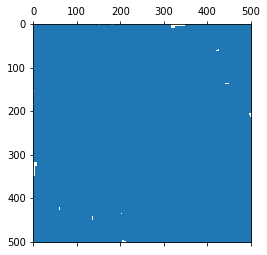

In [6]:
plt.spy(sphere.stiffness)

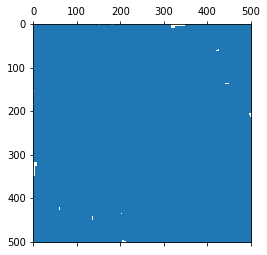

In [7]:
plt.spy(sphere.mass)

In [8]:
sphere.plotting.update({
    'elevation': 0,
    'azimuth': 0,
    'distance': 8,
    'vertex_size': 10,
    'vertex_color': (0, 0, 0, 1),
    'edge_color': (0.5, 0.5, 0.5, 0.2),
})

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x7f76885de438>)

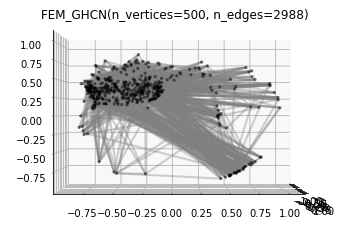

In [9]:
sphere.plot(edges=True)

### 2.2)  Compute the eigenvectors of B^{-1}A

In [10]:
sphere.e(N=50)

<Parameter set "slepc_eigenvalue_solver" containing 8 parameter(s) and parameter set(s)>

  slepc_eigenvalue_solver  |    type          value    range  access  change
  --------------------------------------------------------------------------
  maximum_iterations       |     int        1000000  Not set       0       0
  problem_type             |  string  gen_hermitian  Not set       0       0
  solver                   |  string        <unset>  Not set       0       0
  spectral_shift           |  double        <unset>  Not set       0       0
  spectral_transform       |  string        <unset>  Not set       0       0
  spectrum                 |  string    target real  Not set       0       0
  tolerance                |  double       0.000001  Not set       0       0
  verbose                  |    bool        <unset>  Not set       0       0
Computing eigenvalues. This can take a minute.


In [12]:
sphere.e_lumped(N=50)

<Parameter set "slepc_eigenvalue_solver" containing 8 parameter(s) and parameter set(s)>

  slepc_eigenvalue_solver  |    type          value    range  access  change
  --------------------------------------------------------------------------
  maximum_iterations       |     int        1000000  Not set       0       0
  problem_type             |  string  gen_hermitian  Not set       0       0
  solver                   |  string        <unset>  Not set       0       0
  spectral_shift           |  double        <unset>  Not set       0       0
  spectral_transform       |  string        <unset>  Not set       0       0
  spectrum                 |  string    target real  Not set       0       0
  tolerance                |  double       0.000001  Not set       0       0
  verbose                  |    bool        <unset>  Not set       0       0
Computing eigenvalues. This can take a minute.


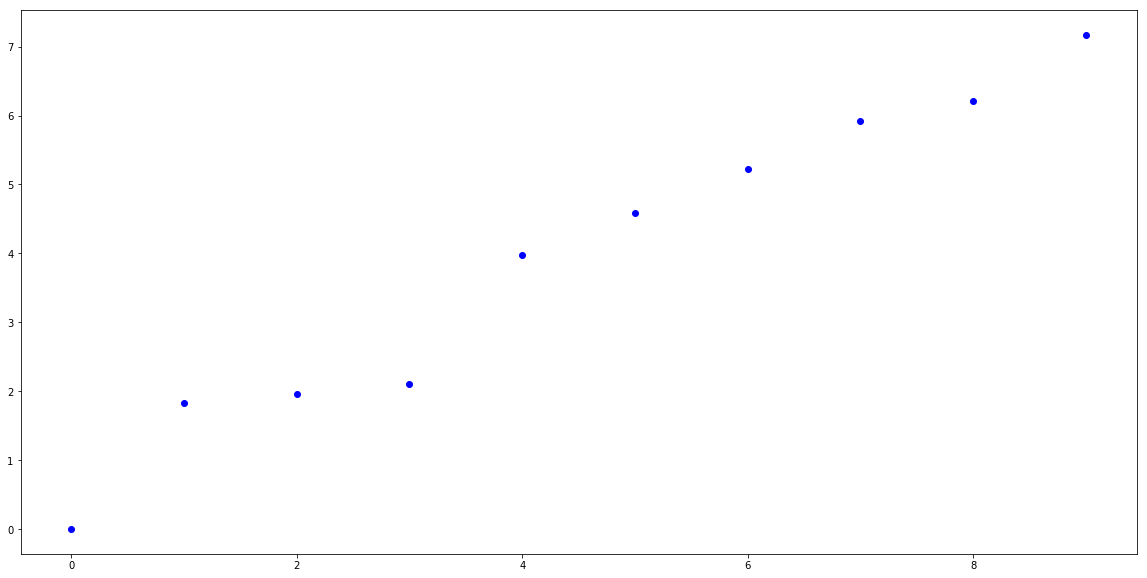

In [18]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(sphere.eig_values[:10], 'bo')

<Parameter set "slepc_eigenvalue_solver" containing 8 parameter(s) and parameter set(s)>

  slepc_eigenvalue_solver  |    type          value    range  access  change
  --------------------------------------------------------------------------
  maximum_iterations       |     int        1000000  Not set       0       0
  problem_type             |  string  gen_hermitian  Not set       0       0
  solver                   |  string        <unset>  Not set       0       0
  spectral_shift           |  double        <unset>  Not set       0       0
  spectral_transform       |  string        <unset>  Not set       0       0
  spectrum                 |  string    target real  Not set       0       0
  tolerance                |  double       0.000001  Not set       0       0
  verbose                  |    bool        <unset>  Not set       0       0
Computing eigenvalues. This can take a minute.


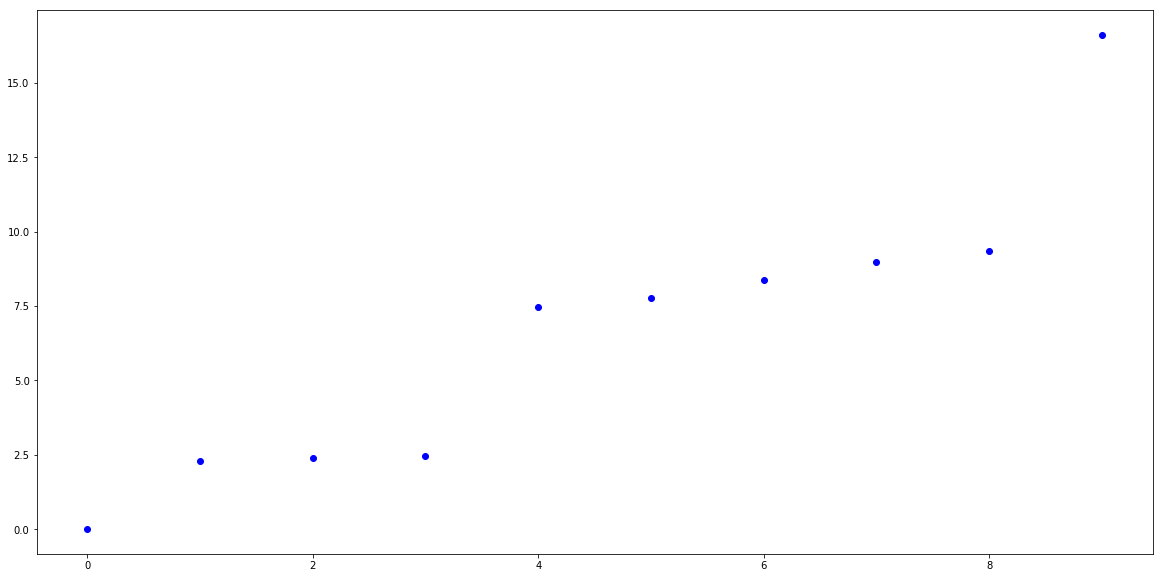

In [19]:
sphere.e(N=50)
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(sphere.eig_values[:10], 'bo')